# Final Predictions

After our grid search, we saw that the combination of Gradient Boost / AdaBoost was still the best option. 

While we weren't able to build a model that lends itself well to tournament play, we did find some that look to do ok with double up and 50/50 play.

This notebook is going to, initially, just do predictions for previous seasons.

Later I hope to use it to generate a player pool for building lineups, with the hopes of eventually completely automating that all together.

Just scroll down to where it says "Start Here" and have some fun with it!

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None # to remove some warnings
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
class Lineup:
    """ 
    takes the results of the model prediction (dataframe 
    with attached predictions) and builds out a few lineups 
    """
    def __init__(self, df, def_df, verbose=False):
        self.verbose = verbose
        self.df = df
        self.def_df = def_df[:15]
        self.current_salary = 100*1000
        self.no_duplicates = False
        self.top_lineups = []
        self.qbs = []
        self.rbs = []
        self.wrs = []
        self.tes = []
        self.flex = []
        self.defs = []
    
    def find_top_10(self, position):
        arr = []
        end_of_range = len(self.df.loc[self.df['Pos']==position])
        if position == 'Flex':
            position_df = self.df.loc[(self.df['Pos']=='RB')|(self.df['Pos']=='TE')|(self.df['Pos']=='WR')]
            end_of_range = (len(self.df.loc[self.df['Pos']=='RB'])+
                            len(self.df.loc[self.df['Pos']=='WR'])+
                            len(self.df.loc[self.df['Pos']=='TE']))
        elif position == 'Def':
            end_of_range = len(self.def_df)
            position_df = self.def_df
            position_df = position_df.sort_values(by='pred', ascending=False)
        else:
            position_df = self.df.loc[self.df['Pos']==position]
        
        # print(position_df)
        for row in range(0,end_of_range):
            player = {
                'name': position_df.iloc[row]['Name'],
                'h/a': position_df.iloc[row]['h/a'],
                'pos': position_df.iloc[row]['Pos'],
                'salary': position_df.iloc[row]['DK salary'],
                'pred_points': position_df.iloc[row]['pred'],
                'act_pts':position_df.iloc[row]['actual_score']
            }
            if len(arr) < end_of_range:
                arr.append(player)
            else: 
                break
        return arr
    
    def get_players(self):
        top_10_qbs = self.find_top_10(position='QB')
        top_10_rbs = self.find_top_10(position='RB')
        top_10_wrs = self.find_top_10(position='WR')
        top_10_tes = self.find_top_10(position='TE')
        top_10_flex = self.find_top_10(position='Flex')
        top_10_defs = self.find_top_10(position='Def')
        return top_10_qbs, top_10_rbs, top_10_wrs, top_10_tes, top_10_flex, top_10_defs
    
    def check_salary(self, lineup):
        current_salary = 0
        for keys in lineup.keys():
            current_salary += lineup[keys]['salary']
        return current_salary
    
    def reduce_salary(self, lineup):
        while self.current_salary > 50*1000:
            position_df = self.df
            greatest_salary = 0
            pos = 'none'
            pos_to_change = 'none'
            for key in lineup.keys():
                if lineup[key]['salary'] > greatest_salary:
                    greatest_salary = lineup[key]['salary']
                    pos = lineup[key]['pos'] # RB, TE, Def, etc.
                    pos_to_change = key # RB1 or WR2 or something like that
            if pos_to_change == 'Def':
                position_df = def_df
            elif pos_to_change == 'Flex':
                position_df = self.df.loc[(self.df['Pos']=='RB')|(self.df['Pos']=='TE')|(self.df['Pos']=='WR')]
            else:
                pass
    #             print(position_df)    
            new_player = (position_df.loc[(position_df.Pos == pos)&(position_df['DK salary'] < greatest_salary)]).sort_values(by='DK salary', ascending=False).head(1)
            player = {
                'name': new_player['Name'].values[0],
                'h/a': new_player['h/a'].values[0],
                'pos': new_player['Pos'].values[0],
                'salary': new_player['DK salary'].values[0],
                'pred_points': new_player['pred'].values[0],
                'act_pts':new_player['actual_score'].values[0]
            }
    #         print(player)    
            lineup[pos_to_change] = player
    #         print(lineup)
            self.current_salary = self.check_salary(lineup)
        return lineup
    
    def check_duplicates(self, lineup):
        rb1_name = lineup['RB1']['name']
        rb2_name = lineup['RB2']['name']
        flex_name = lineup['Flex']['name']
        wr1_name = lineup['WR1']['name']
        wr2_name = lineup['WR2']['name']
        wr3_name = lineup['WR3']['name']
        te_name = lineup['TE']['name']
        names = [flex_name, rb1_name, rb2_name, wr1_name, wr2_name, wr3_name, te_name]
        while len(names) > 1:
            if names[0] in names[1:-1]:
                return False
            else:
                names.pop(0)   
        return True
    
    def shuffle_players(self):
        lineup = {
            'QB': self.qbs[random.randrange(len(self.df.loc[self.df['Pos']=='QB']))],
            'RB1': self.rbs[random.randrange(len(self.df.loc[self.df['Pos']=='RB']))],
            'RB2': self.rbs[random.randrange(len(self.df.loc[self.df['Pos']=='RB']))],
            'WR1': self.wrs[random.randrange(len(self.df.loc[self.df['Pos']=='WR']))],
            'WR2': self.wrs[random.randrange(len(self.df.loc[self.df['Pos']=='WR']))],
            'WR3': self.wrs[random.randrange(len(self.df.loc[self.df['Pos']=='WR']))],
            'TE': self.tes[random.randrange(len(self.df.loc[self.df['Pos']=='TE']))],
            'Flex': self.flex[random.randrange(len(self.df.loc[self.df['Pos']=='RB'])+
                                               len(self.df.loc[self.df['Pos']=='WR'])+
                                               len(self.df.loc[self.df['Pos']=='TE']))],
            'Def': self.defs[random.randrange(len(self.def_df))]
        }
        return lineup
    
    def build_lineup(self,verbose=False):
        # in theory, because of the legwork done by the algorithm,
        # any lineup should be good as long as it abides by the
        # constraints of DraftKings' team structures. So for
        # now, this will just give us the lineups that fit within
        # the salary cap and team requirements
        
        self.verbose = verbose
        self.current_salary = 100*1000
        self.no_duplicates = False
        if len(self.qbs) < 1:
            self.qbs, self.rbs, self.wrs, self.tes, self.flex, self.defs = self.get_players()
        lineup = self.shuffle_players()
        
        while True:
            if self.verbose:
                print('======================')
                print(f"Salary: {self.current_salary}")
                print(f"No Duplicates: {self.no_duplicates}")
                print('======================')
            self.no_duplicates = self.check_duplicates(lineup)
            self.current_salary = self.check_salary(lineup)
            # fix duplicates first
            if self.no_duplicates == False:
                lineup = self.shuffle_players()
            # check salary, making sure it's between 45k and 50k
            if self.current_salary > 50*1000:
                try:
                    lineup = self.reduce_salary(lineup)
                except:
                    lineup = self.shuffle_players()
            self.no_duplicates = self.check_duplicates(lineup)
            self.current_salary = self.check_salary(lineup)
            
            if (self.current_salary <= 50*1000 
#             and self.current_salary >= 45*1000 
            and self.no_duplicates):
                # if everything looks good, end the 
                # loop and append the lineup
                break
                
        
        self.top_lineups.append(lineup)
        if len(self.top_lineups) % 5 == 0:
            print(f"Added lineup. Total lineups: {len(self.top_lineups)}")
    


In [3]:
# Helper Functions

def get_weekly_data(week, year):
    """ get player data for designated week """
    file_path = f"./csv's/{year}/year-{year}-week-{week}-DK-player_data.csv"
    df = pd.read_csv(file_path)
    return df

def get_ytd_season_data(year, current_week):
    """ get data for current season up to most recent week """
    df = get_weekly_data(1,year)
    for week in range(2,current_week+1):
        try:
            df = df.append(get_weekly_data(week, year), ignore_index=True)
        except:
            print("No data for week: "+str(week))
    df = df.drop(['Unnamed: 0', 'Year'], axis=1)
    return df

def get_season_data(year, drop_year=True):
    """ get entire season of data """
    df = get_weekly_data(1,year)
    for week in range(2,17):
        try:
            df = df.append(get_weekly_data(week, year), ignore_index=True)
        except:
            print("No data for week: "+str(week))
    if drop_year:
        df = df.drop(['Unnamed: 0', 'Year'], axis=1)
    else:
        df = df.drop(['Unnamed: 0'], axis=1)
    return df

def scale_features(sc_salary, sc_points, sc_pts_ald, X_train, X_test, first_time=False):
    """ scales data for training """
    if first_time:
        X_train['DK salary'] = sc_salary.fit_transform(X_train['DK salary'].values.reshape(-1,1))
#         X_train['Oppt_pts_allowed_lw'] = sc_pts_ald.fit_transform(X_train['Oppt_pts_allowed_lw'].values.reshape(-1,1))
    X_test['DK salary'] = sc_salary.transform(X_test['DK salary'].values.reshape(-1,1))
#     X_test['Oppt_pts_allowed_lw'] = sc_pts_ald.transform(X_test['Oppt_pts_allowed_lw'].values.reshape(-1,1))
    return X_train, X_test

def unscale_features(sc_salary, sc_points, sc_pts_ald, X_train, X_test):
    """ used to change features back so that human readable information can be used to assess
    lineups and player information and performance"""
    X_train['DK salary'] = sc_salary.inverse_transform(X_train['DK salary'].values.reshape(-1,1))
#     X_train['Oppt_pts_allowed_lw'] = sc_pts_ald.inverse_transform(X_train['Oppt_pts_allowed_lw'].values.reshape(-1,1))
    X_test['DK salary'] = sc_salary.inverse_transform(X_test['DK salary'].values.reshape(-1,1))
#     X_test['avg_points'] = sc_points.inverse_transform(X_test['avg_points'].values.reshape(-1,1))
#     X_test['Oppt_pts_allowed_lw'] = sc_pts_ald.inverse_transform(X_test['Oppt_pts_allowed_lw'].values.reshape(-1,1))
    return X_train, X_test

def handle_nulls(df):
    # players that have nulls for any of the columns are 
    # extremely likely to be under performing or going into a bye.
    # the one caveat is that some are possibly coming off a bye.
    # to handle this later, probably will drop them, save those
    # as a variable, and then re-merge after getting rid of the other
    # null values.
    df = df.dropna()
    return df

def eval_model(df):
    df['score_ratio'] = round(df['actual_score'] / df['pred'],4)
    return df

def remove_outliers_btwn_ij(df, i=-1, j=5):
    s = df.loc[(df.score_ratio > i) & (df.score_ratio < j)]
    return s, i, j

def get_RMSE(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    return RMSE

def summarize_df(df, o_u_thresh=15):
    df = eval_model(df)
    RMSE = get_RMSE(df['actual_score'], df['pred'])
    print(f"Total entries analyzed: {len(df)}")
    s, i, j = remove_outliers_btwn_ij(df)
    print(f"Total entries after outliers removed: {len(s)}. Left boundary: {i}x Right Boundary: {j}x")
    correct_preds_over_thresh = s[(s.pred >= o_u_thresh)&(s.actual_score>=o_u_thresh)]
    correct_preds_under_thresh = s[(s.pred <= o_u_thresh)&(s.actual_score<=o_u_thresh)]
    incorrect_preds_under_thresh = s[(s.pred <= o_u_thresh)&(s.actual_score>=o_u_thresh)]
    incorrect_preds_over_thresh = s[(s.pred >= o_u_thresh)&(s.actual_score<=o_u_thresh)]
    print(f"Correct predictions of over {o_u_thresh} pts: {len(correct_preds_over_thresh)}. Percent: {round(len(correct_preds_over_thresh)/len(s)*100,2)}") # True Positive
    print(f"Correct predictions of under {o_u_thresh} pts: {len(correct_preds_under_thresh)}. Percent: {round(len(correct_preds_under_thresh)/len(s)*100,2)}") # True Negative
    print(f"Incorrect predictions of over {o_u_thresh} pts: {len(incorrect_preds_over_thresh)}. Percent: {round(len(incorrect_preds_over_thresh)/len(s)*100,2)}") # False Positive
    print(f"Incorrect predictions of under {o_u_thresh} pts: {len(incorrect_preds_under_thresh)}. Percent: {round(len(incorrect_preds_under_thresh)/len(s)*100,2)}") # False Negative
    print(f"RMSE: {RMSE}")
    print("Ignore following metrics for filtered DF:")
    print(f"Total percent correct over {o_u_thresh}: {round(len(correct_preds_over_thresh)/len(s)*100,2)-round(len(incorrect_preds_over_thresh)/len(s)*100,2)}")
    print(f"Total percent correct under {o_u_thresh}: {round(len(correct_preds_under_thresh)/len(s)*100,2)-round(len(incorrect_preds_under_thresh)/len(s)*100,2)}")

def invert_one_hot_encode(df, cols=None, sub_strs=None):
    df['Name'] = (df.iloc[:, 3:len(df)] == 1).idxmax(1).str.replace('Name_', "")
    subset = ['Week', 'DK salary', 'Oppt_pts_allowed_lw', 'Name']
    new_df = df[subset]
    return new_df


# Start Here

Just type in a season, and a week, run the notebook, and watch the results at the end!

In [4]:
season = 2020
week = 6

In [5]:
next_week = week + 1
dataset = get_season_data(season)
df = handle_nulls(dataset)
def_df = df.loc[df.Pos == 'Def']
def_df['fantasy_points_allowed_lw'] = 0
df['Oppt_pts_allowed_lw'] = 0
def_teams = [x for x in def_df['Team'].unique()]

def_df['pred'] = 1
def_df = def_df.rename(columns={'DK points': 'actual_score'})
def_df

for week in range(1,17):
    for team in def_teams:
        try:
            offense_df1 = df.loc[(df['Oppt']==team)&(df['Week']==week)]
            offense_df2 = df.loc[(df['Oppt']==team)&(df['Week']==week+1)]
            sum_ = offense_df1['DK points'].sum()
            def_df.loc[(df['Team']==team)&(df['Week']==week+1), 'fantasy_points_allowed_lw'] = sum_
            df.loc[(df['Oppt']==team)&(df['Week']==week+1), 'Oppt_pts_allowed_lw'] = sum_
        except:
            print('couldnt append data')
            pass
df = df[df.Week != 1] 
X = df.drop(labels='DK points', axis=1)
y = df['DK points']
X2 = pd.get_dummies(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state = 42)

In [7]:
ab_reg = AdaBoostRegressor(**{'learning_rate': 0.02, 
                              'loss': 'exponential', 
                              'n_estimators': 100}) 
gb_reg = GradientBoostingRegressor(**{'learning_rate': 0.05, 
                                      'max_depth': 3, 
                                      'max_features': 'auto', 
                                      'min_samples_leaf': 2})
ab_reg.fit(X_train, y_train)
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_features='auto',
                          min_samples_leaf=2)

In [8]:
y_pred = gb_reg.predict(X_test)

In [9]:
X_test['pred'] = y_pred

df_filtered = X_test.loc[X_test['pred']>=15]

X_test = X_test.drop(columns='pred')
df_filtered = df_filtered.drop(columns='pred')

In [10]:
y_pred2 = ab_reg.predict(df_filtered)

In [11]:
for col in df_filtered.columns:
    try:
        if df_filtered[col].sum() == 0:
            df_filtered.drop(columns=[col], inplace=True)
    except:
        pass

df_filtered

,Week,DK salary,Oppt_pts_allowed_lw,"Name_Adams, Davante","Name_Allen, Josh","Name_Allen, Keenan","Name_Anderson, Robby","Name_Andrews, Mark","Name_Barkley, Saquon","Name_Beckham Jr., Odell",...,Oppt_nwe,Oppt_nyg,Oppt_nyj,Oppt_phi,Oppt_pit,Oppt_sea,Oppt_sfo,Oppt_tam,Oppt_ten,Oppt_was
5857,15,9400.0,124.80,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4830,13,6400.0,106.82,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4826,13,6200.0,99.90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1922,5,6700.0,118.92,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
761,2,7000.0,69.22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,15,7500.0,121.36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
885,3,6200.0,85.06,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5865,15,8600.0,100.20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4852,13,6900.0,79.60,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [12]:
inverted_df = invert_one_hot_encode(df_filtered)
inverted_df['pred'] = y_pred2

In [13]:
final_df_results = inverted_df.sort_values(by=['Week', 'DK salary'])

In [14]:
week_arr = [num for num in final_df_results['Week']]
player_arr = [name for name in final_df_results['Name']]

In [15]:
for i in range(len(final_df_results)):
    h_a = df.loc[(df['Week']==week_arr[i])
                           &(df['Name']==player_arr[i]), 'h/a']
    score = df.loc[(df['Week']==week_arr[i])
                           &(df['Name']==player_arr[i]), 'DK points']
    pos = df.loc[(df['Week']==week_arr[i])
                           &(df['Name']==player_arr[i]), 'Pos']
    
    final_df_results.loc[(final_df_results['Week']==week_arr[i])
                         &(final_df_results['Name']==player_arr[i]), 'h/a'] = h_a
    final_df_results.loc[(final_df_results['Week']==week_arr[i])
                         &(final_df_results['Name']==player_arr[i]), 'Pos'] = pos
    final_df_results.loc[(final_df_results['Week']==week_arr[i])
                         &(final_df_results['Name']==player_arr[i]), 'actual_score'] = score

In [16]:
final_df_results

,Week,DK salary,Oppt_pts_allowed_lw,Name,pred,h/a,Pos,actual_score
663,2,4400.0,88.32,"Jefferson, Justin",9.793494,a,WR,7.40
465,2,5800.0,97.92,"Bridgewater, Teddy",17.722317,a,QB,14.68
450,2,5800.0,81.94,"Minshew, Gardner",17.722317,a,QB,28.46
609,2,6300.0,139.48,"Cooper, Amari",14.932018,h,WR,19.00
788,2,6300.0,116.14,"Andrews, Mark",14.932018,a,TE,3.90
...,...,...,...,...,...,...,...,...
6165,16,7600.0,154.46,"Ekeler, Austin",20.192369,h,RB,15.80
6106,16,7600.0,67.40,"Watson, Deshaun",22.755474,h,QB,30.76
6150,16,7900.0,92.18,"Kamara, Alvin",20.758164,h,RB,59.20
6117,16,8500.0,131.70,"Mahomes II, Patrick",23.447711,h,QB,20.22


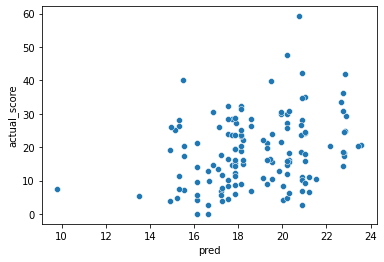

In [24]:
sns.scatterplot(data=final_df_results, x="pred", y="actual_score");

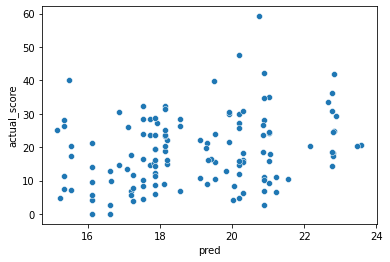

In [25]:
over_15 = final_df_results.loc[final_df_results['pred']>=15]
sns.scatterplot(data=over_15, x="pred", y="actual_score");

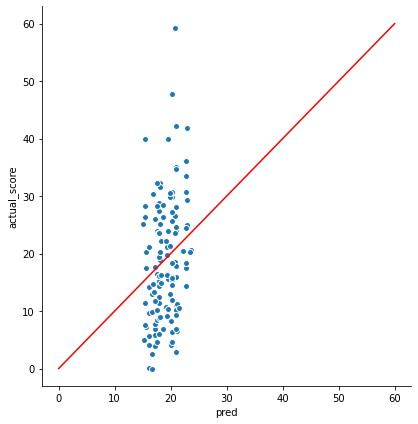

In [38]:
X_plot = np.linspace(0, 60)

g = sns.FacetGrid(over_15, height = 6)
g = g.map(plt.scatter, "pred", "actual_score", edgecolor="w")
plt.plot(X_plot, X_plot, color='r')
plt.show()

In [41]:
pd.set_option("display.max_rows", None, "display.max_columns", 20)
ratio = final_df_results['actual_score'] / final_df_results['pred']
final_df_results['ratio'] = ratio
best_players = final_df_results.loc[final_df_results['ratio']>=1]
best_players

,Week,DK salary,Oppt_pts_allowed_lw,Name,pred,h/a,Pos,actual_score,ratio
450,2,5800.0,81.94,"Minshew, Gardner",17.722317,a,QB,28.46,1.605885
609,2,6300.0,139.48,"Cooper, Amari",14.932018,h,WR,19.00,1.272434
456,2,6300.0,105.86,"Roethlisberger, Ben",18.200620,h,QB,22.24,1.221936
599,2,6400.0,96.76,"Evans, Mike",15.331219,h,WR,26.40,1.721977
761,2,7000.0,69.22,"Kelce, Travis",17.521468,a,TE,24.00,1.369748
881,3,5300.0,108.76,"Fitzpatrick, Ryan",15.151614,a,QB,25.20,1.663189
895,3,5400.0,128.72,"Carr, Derek",15.532714,a,QB,17.44,1.122792
887,3,6200.0,124.48,"Burrow, Joe",18.130894,a,QB,23.38,1.289512
885,3,6200.0,85.06,"Brees, Drew",18.130894,h,QB,23.52,1.297233
1028,3,6400.0,119.52,"Lockett, Tyler",15.487540,h,WR,40.00,2.582721
